In [5]:
import numpy as np
from scipy.special import kv, gamma
from copy import deepcopy
from variogram import *
import matplotlib.pyplot as plt

In [8]:
ndim = 2
mu1 = np.ones(ndim) * 3
mu2 = np.ones(ndim) * 0
mu3 = np.ones(ndim) * (-3)
sig = np.eye(ndim,ndim) * 0.75

group1 = np.random.multivariate_normal(mu1,sig,100)
group2 = np.random.multivariate_normal(mu2,sig,100)
group3 = np.random.multivariate_normal(mu3,sig,100)
groups = np.concatenate((group1,group2,group3))
copied = deepcopy(groups)
distances = np.linalg.norm(copied[:,np.newaxis] - copied[np.newaxis,:],axis=2)
absolute_distances = np.abs(distances)






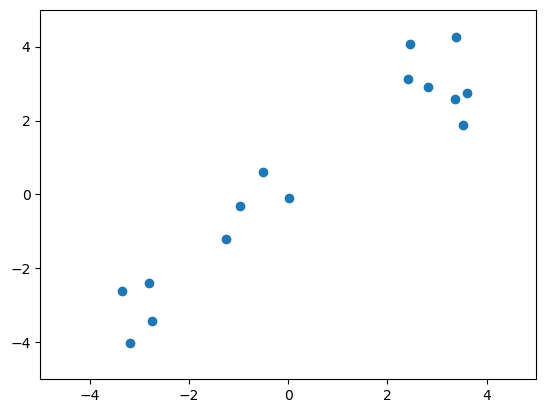

In [9]:
plt.scatter(groups[:15,0],groups[:15,1])

plt.ylim(-5,5)
plt.xlim(-5,5)

plt.show()

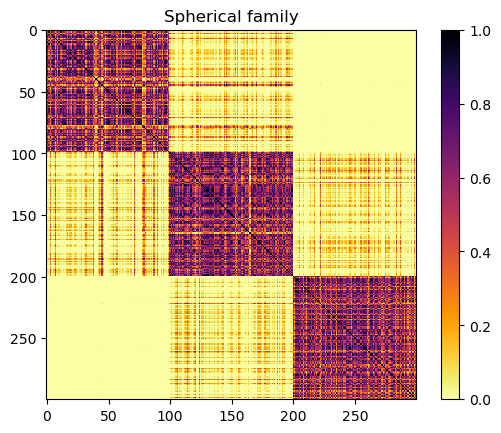

In [10]:
sph = spherical_family(absolute_distances,5)
plt.imshow(sph, cmap='inferno_r', interpolation='nearest')
plt.colorbar()
plt.title('Spherical family')
plt.show()

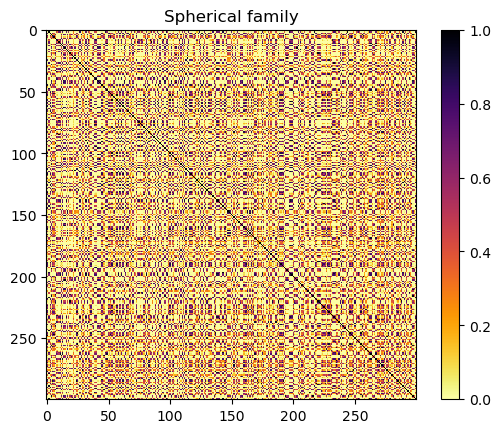

In [11]:
sph = spherical_family(shuffled_absolute_distances,5)
plt.imshow(sph, cmap='inferno_r', interpolation='nearest')
plt.colorbar()
plt.title('Spherical family')
plt.show()

In [17]:
help(np.sort)

Help on _ArrayFunctionDispatcher in module numpy:

sort(a, axis=-1, kind=None, order=None)
    Return a sorted copy of an array.
    
    Parameters
    ----------
    a : array_like
        Array to be sorted.
    axis : int or None, optional
        Axis along which to sort. If None, the array is flattened before
        sorting. The default is -1, which sorts along the last axis.
    kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
        Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
        and 'mergesort' use timsort or radix sort under the covers and, in general,
        the actual implementation will vary with data type. The 'mergesort' option
        is retained for backwards compatibility.
    
        .. versionchanged:: 1.15.0.
           The 'stable' option was added.
    
    order : str or list of str, optional
        When `a` is an array with fields defined, this argument specifies
        which fields to compare first, second,

In [22]:

sorted_groups = np.sort(groups,axis=0)
sorted_groups = np.sort(sorted_groups,axis=1)

distances = np.linalg.norm(sorted_groups[:,np.newaxis] - sorted_groups[np.newaxis,:],axis=2)
sorted_absolute_distances = np.abs(distances)


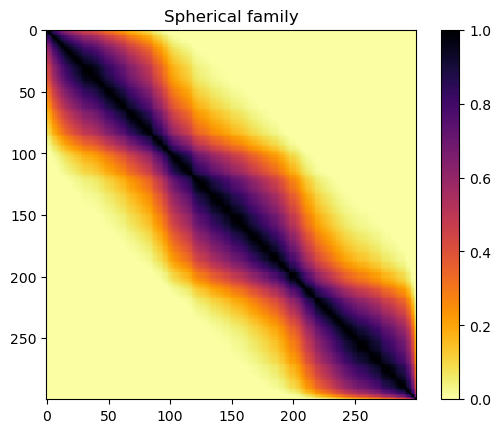

In [23]:
sph = spherical_family(sorted_absolute_distances,5)
plt.imshow(sph, cmap='inferno_r', interpolation='nearest')
plt.colorbar()
plt.title('Spherical family')
plt.show()